In [1]:
## External Libraries
import sys
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from autoencode import AEEnsemble
from datasets import UnsupervisedDataset, SupervisedDataset, BenchmarkDataset
from sklearn.mixture import GaussianMixture
# !pip install graspologic
from graspologic.utils import remap_labels
import seaborn as sns
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

sns.set_theme()
sns.set_context("paper")
sns.set(font_scale=1)

# General Data Directory ##TODO: Please fill in the appropriate directory
# os.chdir("/content/")
data_dir = "/export/gaon1/data/jteneggi/DL/pedreira"
results_dir = "results"

In [2]:
from autoencode import AEEnsemble
from models import Classifier
from datasets import SupervisedDataset, UnsupervisedDataset

In [3]:
unsup_data = UnsupervisedDataset("/export/gaon1/data/jteneggi/DL/alm", session_idx=[0])
unsup_spikes = []
for idx, (_unsup_spikes, _) in enumerate(unsup_data):
    if len(_unsup_spikes) > 0:
        # print(_unsup_spikes.shape)
        unsup_spikes.append(_unsup_spikes)
unsup_spikes = np.concatenate(unsup_spikes)
print(unsup_spikes.shape)

(423520, 39)


In [4]:
sup_spikes, sup_targets = SupervisedDataset("/export/gaon1/data/jteneggi/DL/pedreira")[0]
print(sup_spikes.shape)

(12012, 39)


In [5]:
spike_batch_size = 128
n_ae_iter = 120
n_class_iter = 6
ratio = n_ae_iter/n_class_iter
sup_L = len(sup_spikes)
unsup_L = len(unsup_spikes)
unsup_epoch_L = int(ratio * sup_L)

print(sup_L, unsup_epoch_L)

12012 240240


In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "9"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

ae = AEEnsemble(batch_size=1, device=device)
ae.load()

Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tensor([[ 0.0281,  0.0628,  0.0562,  0.0038, -0.0009,  0.0031,  0.0301,  0.0447,
         -0.0073,  0.0119,  0.3672,  0.6488,  0.1150, -0.3993, -0.5423, -0.5292,
         -0.4060, -0.2612, -0.1412, -0.0563,  0.0571,  0.1361,  0.0787, -0.0071,
         -0.0249,  0.0069,  0.0644,  0.1254,  0.0958, -0.0368, -0.0680, -0.0390,
         -0.0127,  0.0062,  0.0397,  0.0898,  0.1075,  0.0857,  0.0431]],
       device='cuda:0')
tensor([[ 0.0176,  0.0287,  0.0294,  0.0246,  0.0207,  0.0201,  0.0235,  0.0275,
          0.0259,  0.0199,  0.0150,  0.0103,  0.0074,  0.0142,  0.0143, -0.0367,
         -0.1459, -0.2440, -0.2611, -0.2086, -0.1446, -0.0952, -0.0528, -0.0136,
          0.0177,  0.0392,  0.0500,  0.0545,  0.0626,  0.0732,  0.0759,  0.0738,
          0.0770,  0.0807,  0.0734,  0.0570,  0.0405,  0.0284,  0.0215]],
       device='cuda:0')


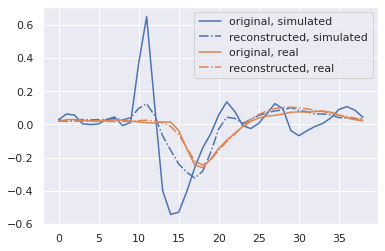

In [13]:
sup_spike_idx = np.random.choice(range(sup_L), 1, replace=False)
unsup_spike_idx = np.random.choice(range(unsup_L), 1, replace=False)

sup_spike = sup_spikes[sup_spike_idx]
unsup_spike = unsup_spikes[unsup_spike_idx]

sup_spike = torch.from_numpy(sup_spike).float().to(device)
unsup_spike = torch.from_numpy(unsup_spike).float().to(device)

latent_vecs = [e(sup_spike) for e in ae.encoders]
reconstructed = [d(latent_vecs[i]) for i, d in enumerate(ae.decoders)]
reconstructed = torch.cat(reconstructed, dim=0).mean(dim=0)

print(sup_spike)
plt.plot(np.transpose(sup_spike.cpu().numpy()), "-", c="C0", label="original, simulated")
plt.plot(np.transpose(reconstructed.detach().cpu().numpy()), "-.", c="C0", label="reconstructed, simulated")

latent_vecs = [e(unsup_spike) for e in ae.encoders]
reconstructed = [d(latent_vecs[i]) for i, d in enumerate(ae.decoders)]
reconstructed = torch.cat(reconstructed, dim=0).mean(dim=0)

print(unsup_spike)
plt.plot(np.transpose(unsup_spike.cpu().numpy()), "-", c="C1", label="original, real")
plt.plot(np.transpose(reconstructed.detach().cpu().numpy()), "-.", c="C1", label="reconstructed, real")

plt.legend()

plt.savefig("example.eps")

<Figure size 432x288 with 0 Axes>